In [1]:

import sys
import os
# setting path
current = os.path.dirname(os.path.realpath('__file__'))
parent = os.path.dirname(current)
sys.path.append(parent)


import brainpy as bp
import brainpy.math as bm

from types import SimpleNamespace
from utils import *

from calc_params import par, update_parameters
from model import Model

c:\Users\dell\anaconda3\envs\brainpy-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initializing Parameters...


In [2]:
f_dir = "crossOutput_noInterneuron_noMTConn_gaussianInOut_WeightLambda1_highTestCoh_model"
lr = 0.02
rep = 0
update_parameters({'rep': rep,
                    'save_fn': 'model_results_%d_lr%f.pkl' % (rep, lr),
                    'batch_size': par['test_batch_size'],
                    'num_iterations': par['num_test_iterations'],
                    'coherence_levels': par['test_coherence_levels'],
                    'weight_fn': 'weight_%d_lr%f.pth' % (rep, lr),
                    'learning_rate': lr})

In [3]:
n = SimpleNamespace(**load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep)))
normalized_h = min_max_normalize(n.h)
normalized_h.shape

(70, 2048, 200)

In [4]:
n.neural_input[45, :, :].shape

(2048, 17)

In [5]:
model = Model(par, n.neural_input, train=False)
model.reset_batch()
# model.temp_h = bm.Variable(model.h[0, :])
finder = bp.analysis.SlowPointFinder(model, args = (n.neural_input[45, 0, :],), target_vars={'h':model.h})


In [6]:
fp_c = normalized_h[45:, :, :]
fp_c = bm.vstack(list(fp_c[i, :, :] for i in range(fp_c.shape[0])))
# fp_c = normalized_h[45, :, :]
fp_candidates = {'h': fp_c}
fp_c.shape

(51200, 200)

In [38]:
finder.find_fps_with_gd_method(
  candidates=fp_candidates, num_opt=5000, tolerance=3e-4
)

Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-100 in 15.23 sec, Training loss 0.0011681784
    Batches 101-200 in 14.99 sec, Training loss 0.0008549280
    Batches 201-300 in 15.13 sec, Training loss 0.0007938439
    Batches 301-400 in 14.96 sec, Training loss 0.0004530186
    Batches 401-500 in 15.00 sec, Training loss 0.0004233957
    Batches 501-600 in 15.06 sec, Training loss 0.0003286334
    Batches 601-700 in 15.16 sec, Training loss 0.0003772981
    Batches 701-800 in 14.83 sec, Training loss 0.0004921164
    Batches 801-900 in 11.75 sec, Training loss 0.0003097324
    Batches 901-1000 in 11.41 sec, Training loss 0.0002840428
    Stop optimization as mean training loss 0.0002840428 is below tolerance 0.0003000000.


In [39]:
# finder.filter_loss(1e-4)
all_fp_losses = finder._losses

(array([   74.,   415.,  1726.,  6954., 16233., 16770.,  7250.,  1431.,
          327.,    20.]),
 array([0.00498693, 0.00503491, 0.00508289, 0.00513087, 0.00517885,
        0.00522683, 0.00527481, 0.00532278, 0.00537076, 0.00541874,
        0.00546672]),
 <BarContainer object of 10 artists>)

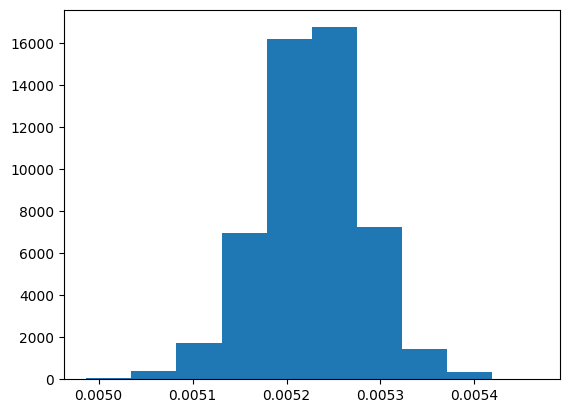

In [40]:
plt.hist(all_fp_losses)

In [41]:
sum(all_fp_losses<0.005)

DeviceArray(3, dtype=int32, weak_type=True)

In [29]:
finder.filter_loss(0.00285)

Excluding fixed points with squared speed above tolerance 0.00285:
    Kept 622/51200 fixed points with tolerance under 0.00285.


In [30]:

finder.keep_unique()

Excluding non-unique fixed points:
    Kept 414/622 unique fixed points with uniqueness tolerance 0.025.


In [32]:
def visualize_fixed_points(fps, plot_ids=(0,), xs=None):
  for i in plot_ids:
    if xs is None:
      plt.plot(fps[i], label=f'FP-{i}')
    else:
      plt.plot(xs, fps[i], label=f'FP-{i}')
  plt.legend()
  plt.xlabel('Feature')
  plt.ylabel('Bump activity')
  plt.show()

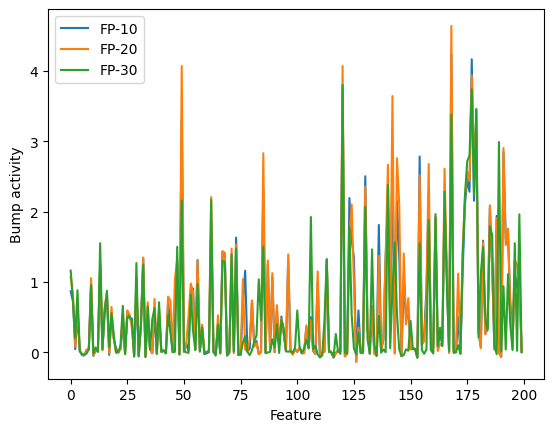

In [35]:
visualize_fixed_points(finder.fixed_points['h'],
                       plot_ids=(10, 20, 30),
                       )

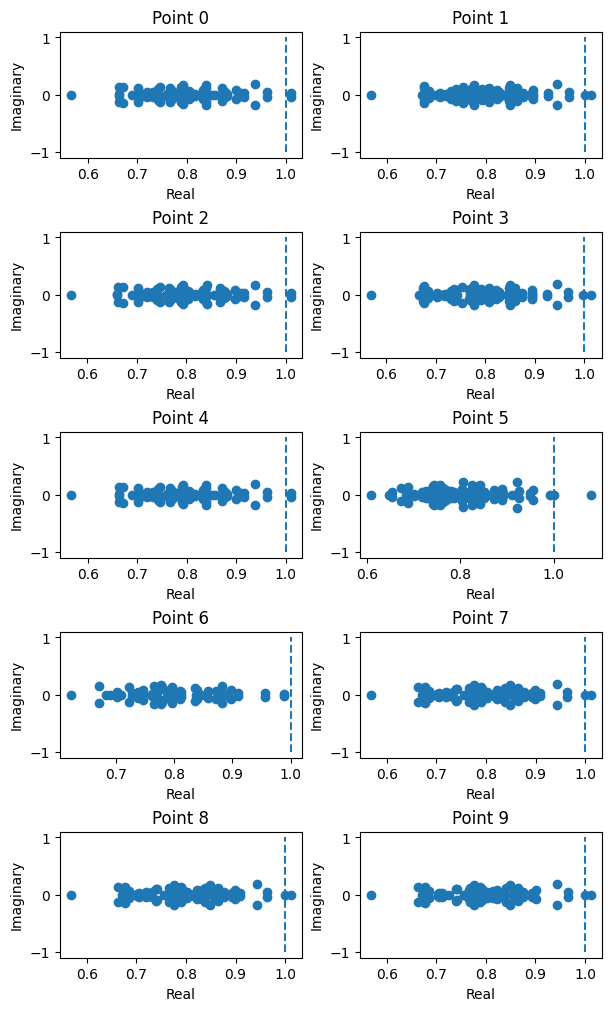

array([[[ 0.8       ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.8       ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.8       , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.8       ,
         -0.02152263,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.03054011,
          0.8       ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.8       ]],

       [[ 0.8       ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.8       ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.8       , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [31]:
from jax import tree_map
fps = tree_map(lambda a: a[-10:], finder._fixed_points)
finder.compute_jacobians(fps, plot=True, num_col=2)